# Esercizio DBSCAN  

## Dati:


fonte: https://archive.ics.uci.edu/ml/datasets/Wholesale+customers

Margarida G. M. S. Cardoso, margarida.cardoso '@' iscte.pt, ISCTE-IUL, Lisbon, Portugal


Data Set Information:

Attribute Information:

    1) FRESH: annual spending (m.u.) on fresh products (Continuous);
    2) MILK: annual spending (m.u.) on milk products (Continuous);
    3) GROCERY: annual spending (m.u.)on grocery products (Continuous);
    4) FROZEN: annual spending (m.u.)on frozen products (Continuous)
    5) DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
    6) DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous);
    7) CHANNEL: customers  Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal)
    8) REGION: customers  Region Lisnon, Oporto or Other (Nominal)
 

Relevant Papers:

Cardoso, Margarida G.M.S. (2013). Logical discriminant models â€“ Chapter 8 in Quantitative Modeling in Marketing and Management Edited by Luiz Moutinho and Kun-Huang Huarng. World Scientific. p. 223-253. ISBN 978-9814407717

Jean-Patrick Baudry, Margarida Cardoso, Gilles Celeux, Maria JosÃ© Amorim, Ana Sousa Ferreira (2012). Enhancing the selection of a model-based clustering with external qualitative variables. RESEARCH REPORT NÂ° 8124, October 2012, Project-Team SELECT. INRIA Saclay - ÃŽle-de-France, Projet select, UniversitÃ© Paris-Sud 11



-----

## DBSCAN e Clustering 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/pg-88/IFOA_ML_AI/main/Risorse/dataset/wholesome-customers-data.csv')

In [3]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


## EDA
Proviamo a vedere come si combinano le varie categorie in funzione di regione e canale di distribuzione

<Axes: xlabel='Grocery', ylabel='Detergents_Paper'>

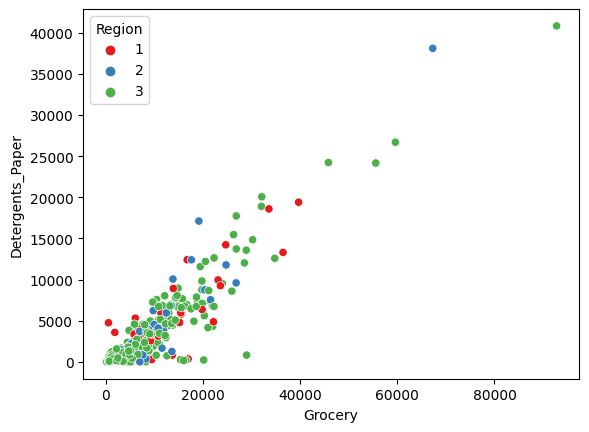

In [10]:
# grocery vs Detergents_Paper

sns.scatterplot(data=df, x='Grocery', y='Detergents_Paper', hue='Region', palette='Set1')

<Axes: xlabel='Grocery', ylabel='Detergents_Paper'>

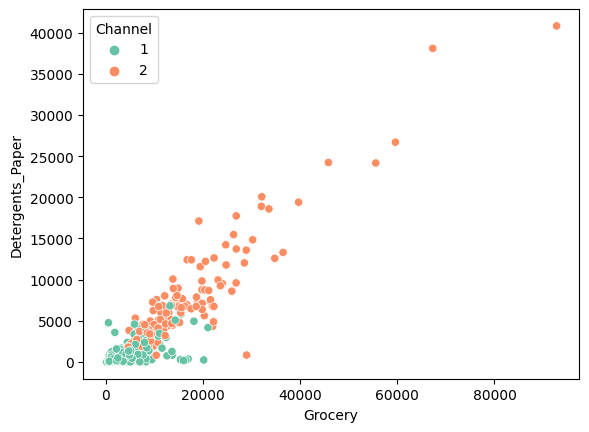

In [9]:

sns.scatterplot(data=df, x='Grocery', y='Detergents_Paper', hue='Channel', palette='Set2')

<Axes: xlabel='Milk', ylabel='Grocery'>

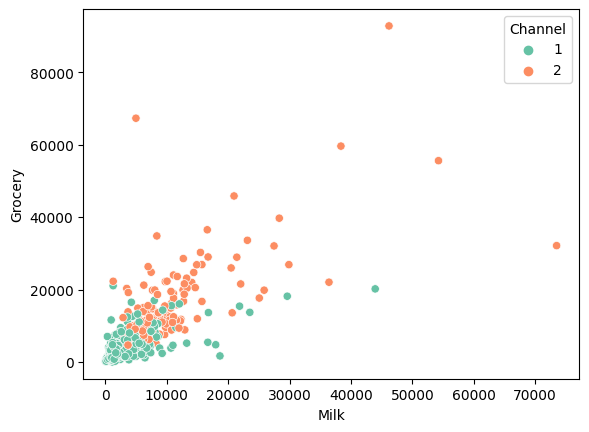

In [11]:
# latte - alimentari in funzione del canale di vendita 
sns.scatterplot(data=df, x='Milk', y='Grocery', hue='Channel', palette='Set2')


<Axes: xlabel='Milk', ylabel='Grocery'>

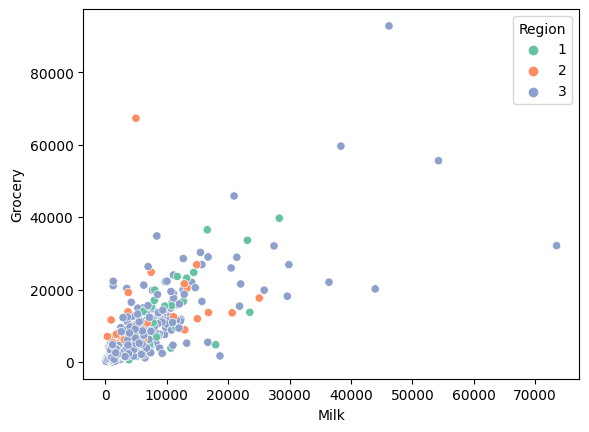

In [16]:

sns.scatterplot(data=df, x='Milk', y='Grocery', hue='Region', palette='Set2')

<Axes: xlabel='Fresh', ylabel='Frozen'>

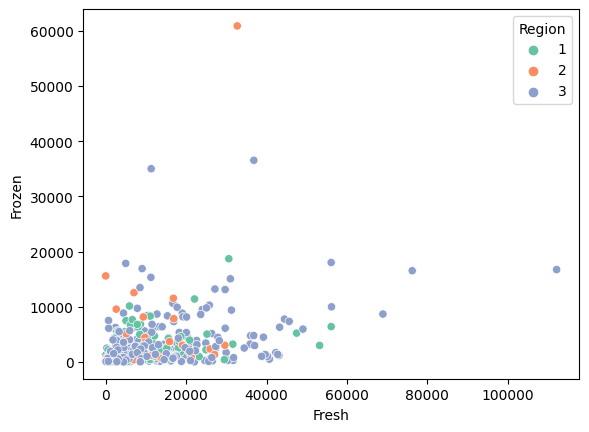

In [44]:
sns.scatterplot(data=df, x='Fresh', y='Frozen', hue='Region', palette='Set2')


<Axes: xlabel='Grocery', ylabel='Count'>

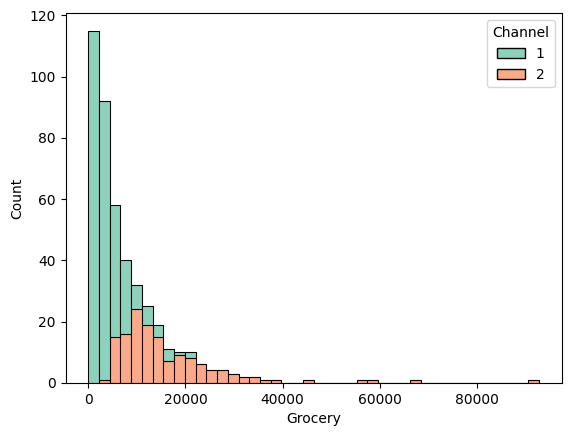

In [25]:
sns.histplot(data=df,  x='Grocery', hue='Channel', palette='Set2', multiple='stack')

<Axes: xlabel='Grocery', ylabel='Count'>

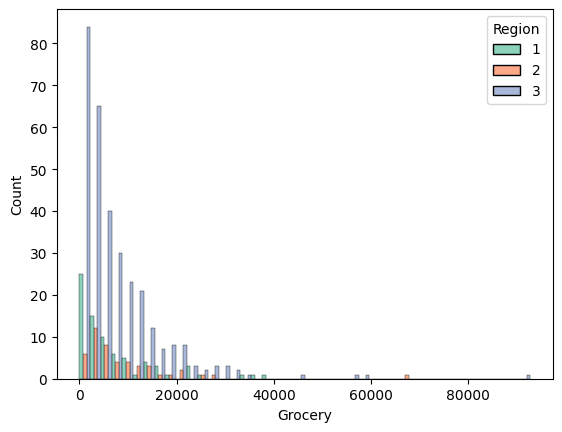

In [28]:
sns.histplot(data=df,  x='Grocery', hue='Region', palette='Set2', multiple='dodge')

<Axes: xlabel='Milk', ylabel='Count'>

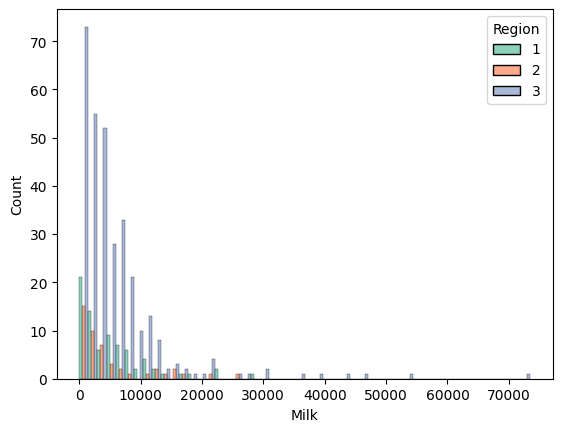

In [31]:
## istogramma con le vendite del latte per canale di vendita
sns.histplot(data=df, x='Milk', hue='Region', palette='Set2', multiple='dodge')

**clustermap della correlazione tra categorie di spesa.**

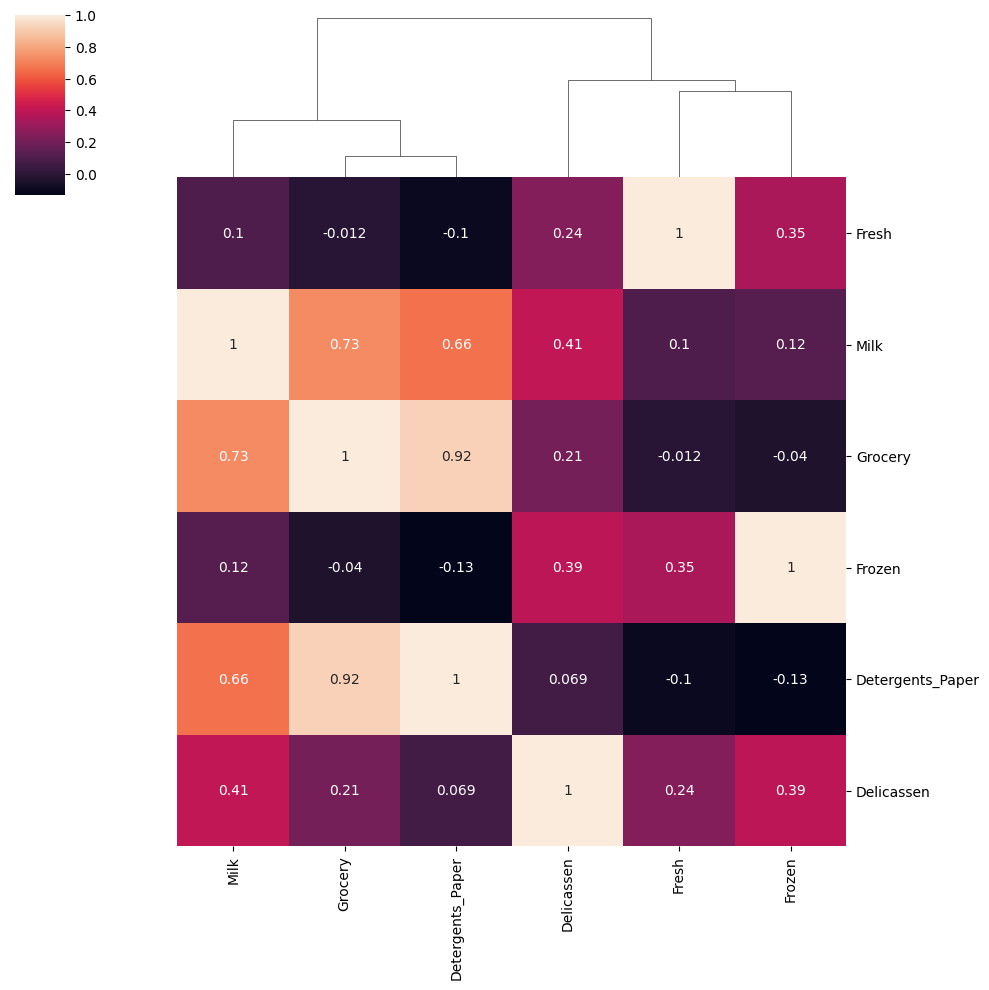

In [45]:

sns.clustermap(data=df.drop(['Region', 'Channel'], axis=1).corr(), row_cluster=False, annot=True)

**PairPlot odel dataframe, colorato per Regione.**

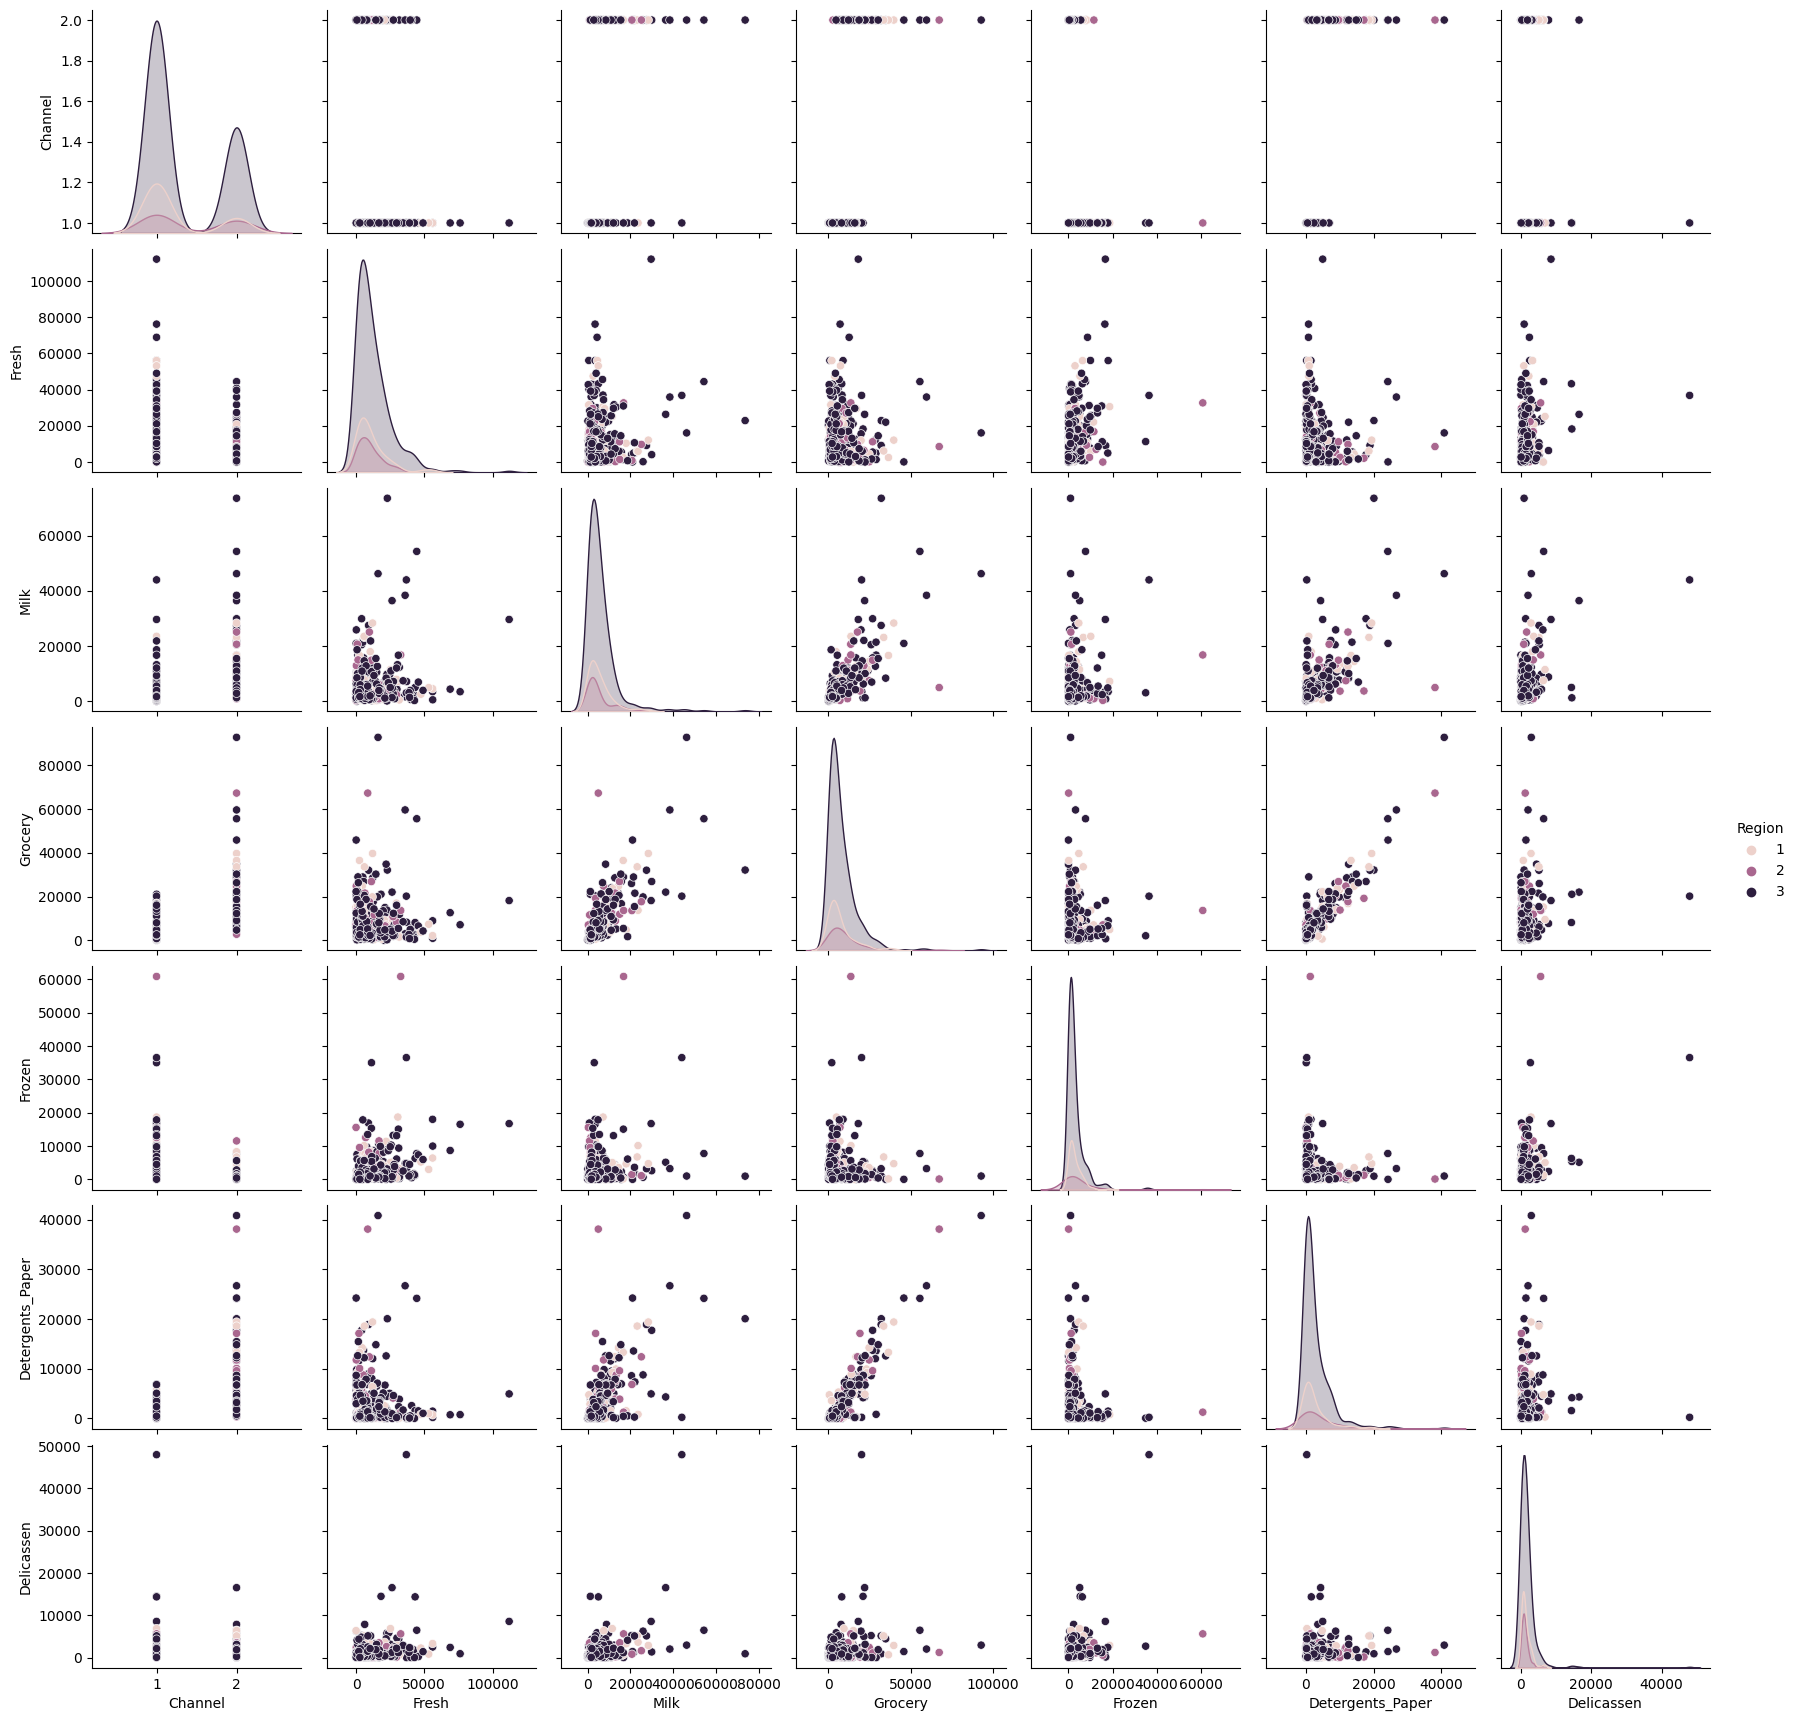

In [47]:
sns.pairplot(data=df, hue='Region')

## DBSCAN

Partiamo scalando i valori

In [48]:
# scalare i dati 

from sklearn.preprocessing import StandardScaler

In [49]:
scaler = StandardScaler()

scaled_X = scaler.fit_transform(df)
scaled_X 

array([[ 1.44865163,  0.59066829,  0.05293319, ..., -0.58936716,
        -0.04356873, -0.06633906],
       [ 1.44865163,  0.59066829, -0.39130197, ..., -0.27013618,
         0.08640684,  0.08915105],
       [ 1.44865163,  0.59066829, -0.44702926, ..., -0.13753572,
         0.13323164,  2.24329255],
       ...,
       [ 1.44865163,  0.59066829,  0.20032554, ..., -0.54337975,
         2.51121768,  0.12145607],
       [-0.69029709,  0.59066829, -0.13538389, ..., -0.41944059,
        -0.56977032,  0.21304614],
       [-0.69029709,  0.59066829, -0.72930698, ..., -0.62009417,
        -0.50488752, -0.52286938]])

**Ciclo per determinare il valore migliore di epsilon**

il valore di n lo poniamo pari al doppio del numero di feature

il range di valori per epsilon sarà:

    np.linspace(0.001,3,50)

In [71]:
from sklearn.cluster import DBSCAN

outlier_percent = []

for eps in np.linspace(0.001, 3, 50):
    dbscan = DBSCAN(eps=eps,min_samples=2*scaled_X.shape[1])
    dbscan.fit(scaled_X)
    
    perc_outliers = 100 * np.sum(dbscan.labels_ == -1) / len(dbscan.labels_)

    outlier_percent.append(perc_outliers)

**Creare un line plot della percentuale di outliers in funzione della epsilon scelta.**

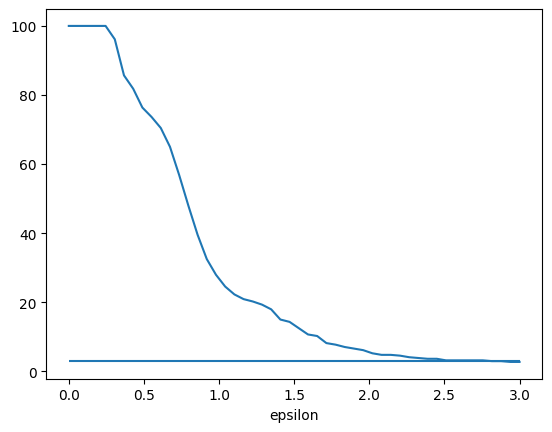

In [72]:
#
sns.lineplot(x=np.linspace(0.001, 3, 50), y=outlier_percent)
plt.xlabel("epsilon")
# plt.ylim(0, 20)
plt.hlines(y=3, xmin=0, xmax=3)

## DBSCAN con la epsilon scelta

**Creare il modello con il valore che cu sembra più appropriato**

In [73]:

dbscan = DBSCAN(eps=2, min_samples=scaled_X.shape[1])
dbscan.fit(scaled_X)

DBSCAN(eps=2, min_samples=8)

**scatterplot di grocery e milk colorati in funzione delle label trovate**

<Axes: xlabel='Grocery', ylabel='Milk'>

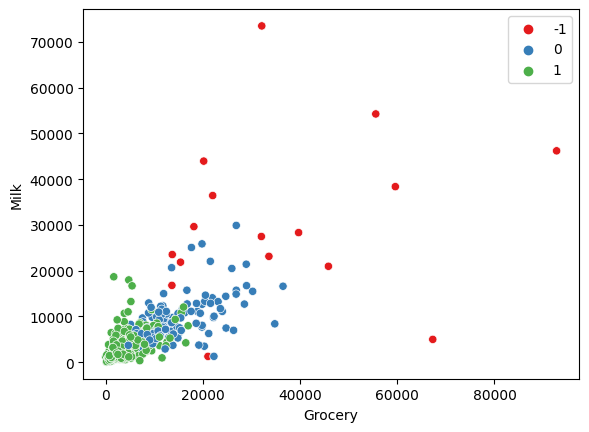

In [74]:
sns.scatterplot(palette='Set1',data=df, x='Grocery', y='Milk', hue=dbscan.labels_)

**scatterplot di Milk vs. Detergents Paper colorate in funzione delle label.**

<Axes: xlabel='Detergents_Paper', ylabel='Milk'>

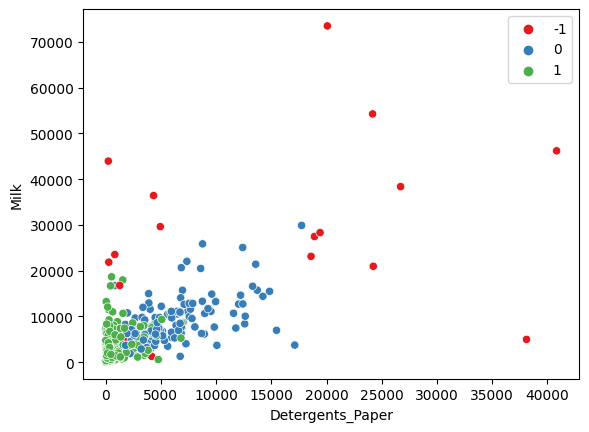

In [76]:
sns.scatterplot(data=df, x='Detergents_Paper', y='Milk', palette='Set1', hue=dbscan.labels_)

**comparare la media delle varie categorie per ciascuna label e per gli outliers**

In [80]:
df['Labels'] = dbscan.labels_

In [81]:
categorie = df.drop(['Channel', 'Region'], axis=1)
cat_media = categorie.groupby('Labels').mean()

In [82]:
cat_media

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Labels,,,,,,
-1,28678.285714,24176.523810,28797.857143,11535.000000,11932.523810,7367.380952
0,8134.862595,8909.916031,14004.427481,1450.595420,6080.832061,1533.519084
1,12542.430556,3039.760417,3677.871528,3192.315972,766.267361,1094.920139


<Axes: ylabel='Labels'>

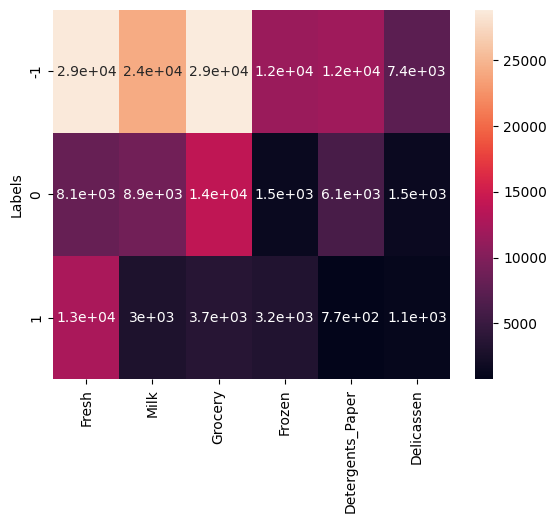

In [84]:
sns.heatmap(cat_media, annot=True)


# outliers sono quelli che spendono di più
# le categorie coi valori più alti sono fresh milk e grocery

<Axes: ylabel='Labels'>

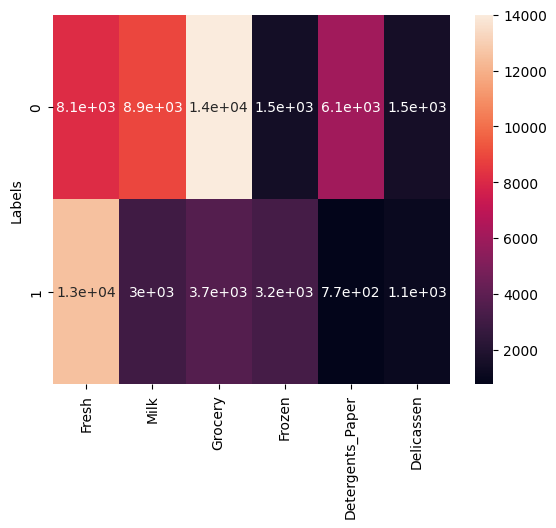

In [85]:
sns.heatmap(cat_media.loc[[0,1]], annot=True)
## solo i cluster senza outlier
## lo 0 spende molto più grocery e fresh

----